In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO # url 받아서 이미지 만드는
import matplotlib.pyplot as plt
import requests

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")



c:\Users\user\anaconda3\envs\bgy_3_12\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


사용 중인 디바이스: cuda


In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

c:\Users\user\anaconda3\envs\bgy_3_12\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\bgy_3_12\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [4]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

In [5]:
def preprocess_image(image):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    return transform(image).unsqueeze(0)


In [6]:
def predict_and_visualize(image_path_or_url, confidence_threshold=0.5):
    if image_path_or_url.startswith("http"):
        image = load_image_from_url(image_path_or_url)
    else:
        image = Image.open(image_path_or_url).convert("RGB")

    image_tensor = preprocess_image(image).to(device)
    with torch.no_grad():
        predictions = model(image_tensor)
    boxes = predictions[0]["boxes"].cpu() # bounding box
    labels = predictions[0]["labels"].cpu() 
    scores = predictions[0]["scores"].cpu()
    mask = scores > confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        rect = plt.Rectangle(
            (x1, y1), width, height, fill=False, color="red", linewidth=2
        )
        ax.add_patch(rect)

        class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        ax.text(
            x1,
            y1 - 5,
            f"{class_name}: {score:.2f}",
            bbox=dict(facecolor="red", alpha=0.8),
            fontsize=10,
            color="white",
        )

    ax.set_title(f"R-CNN 객체 탐지 결과 (탐지된 객체: {len(boxes)}개)")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\n탐지된 객체들:")
    for i, (label, score) in enumerate(zip(labels, scores)):
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        print(f"{i+1}. {class_name}: {score:.3f}")

=== 웹 이미지로 R-CNN 테스트 ===


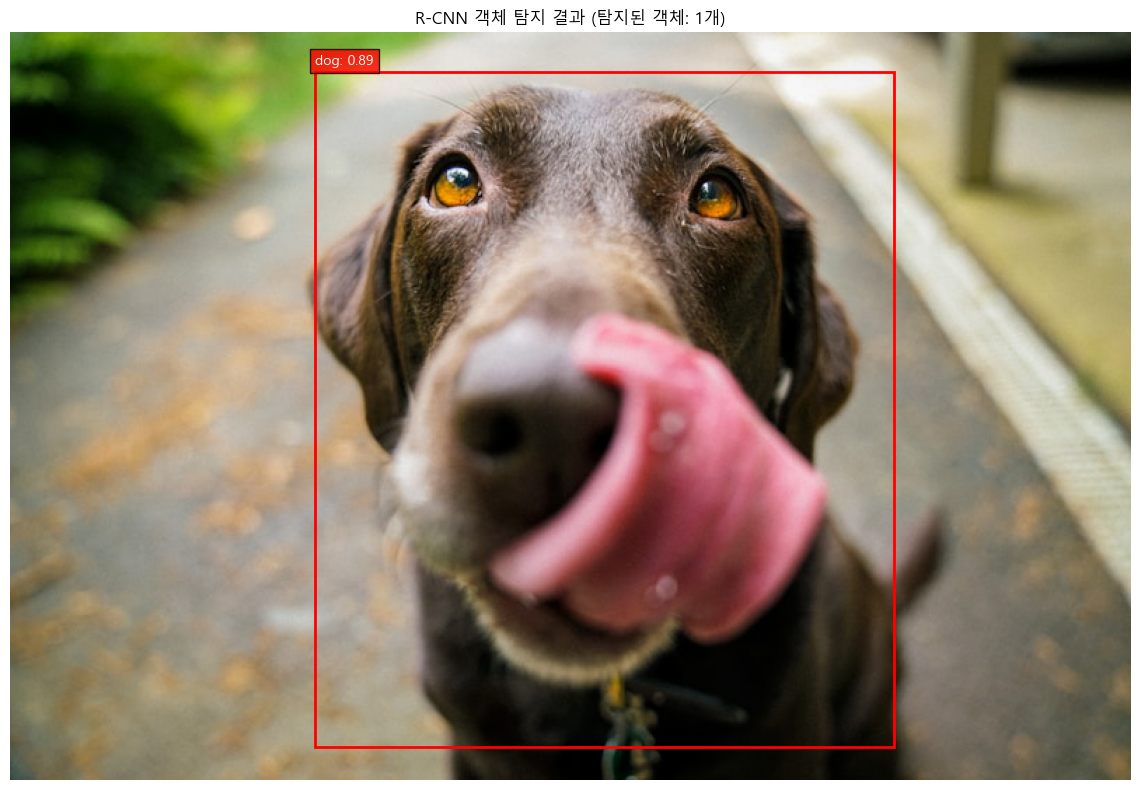


탐지된 객체들:
1. dog: 0.894


In [7]:
if __name__ == "__main__":
    sample_url = "https://images.unsplash.com/photo-1518717758536-85ae29035b6d?w=800"
    print("=== 웹 이미지로 R-CNN 테스트 ===")
    predict_and_visualize(sample_url, confidence_threshold=0.7)